In [39]:
# Preprocessing & results----------------
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
# nlp preprocessing
import spacy
# Models-------------------------
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process import GaussianProcessClassifier
import sklearn.gaussian_process.kernels as kls
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
# for visualizing ---------------
import pydotplus
from sklearn import tree
from sklearn.externals.six import StringIO 
from IPython.display import Image, display
import seaborn as sns
# General purpose
import re
import pandas as pd
import pickle
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# Fix the lastest ref feature

In [2]:
data = pd.read_pickle('./features/all_data_features_csv_17_20_new.pkl')
print(data.shape)
data.head(5)

(4897, 24)


,id,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,n_keywords,ref_len,ref_latest,num_recent_refs,...,avg_ref_length,num_sections,contains_appendix,fig_tab_eqn_count,contains_table,contains_figure,contains_equation,iclr_references,label,ref_latest_depth
2017_HJIY0E9ge,2017_HJIY0E9ge,3,70,12,823,121,1,22,2016,12,...,250,13,0,25,1,1,1,0,Reject,2
2017_BkdpaH9ll,2017_BkdpaH9ll,5,41,5,1076,149,2,30,2016,24,...,48,14,0,10,1,1,1,2,Reject,2
2020_rkecl1rtwB,2020_rkecl1rtwB,2,40,6,918,134,3,16,2019,12,...,41,24,1,20,1,1,1,3,Accept,2
2019_HkgYmhR9KX,2019_HkgYmhR9KX,5,75,11,1761,266,4,36,2019,24,...,48,16,1,26,1,1,1,0,Accept,1
2020_ryxW804FPH,2020_ryxW804FPH,3,68,8,750,112,4,31,2019,20,...,33,10,1,17,1,1,1,2,Reject,2


In [4]:
data.columns

Index(['id', 'n_authors', 'len_char_title', 'len_word_title',
       'len_char_abstract', 'len_word_abstract', 'n_keywords', 'ref_len',
       'ref_latest', 'num_recent_refs', 'contains_ml_keyword', 'avg_sent_len',
       'abs_glove_avg', 'contains_sota', 'avg_ref_length', 'num_sections',
       'contains_appendix', 'fig_tab_eqn_count', 'contains_table',
       'contains_figure', 'contains_equation', 'iclr_references', 'label',
       'ref_latest_depth'],
      dtype='object')

In [5]:
data["ref_latest_depth"] = data["id"].apply(lambda x: int(x.split("_")[0])) - data["ref_latest"] + 1

In [6]:
data.to_pickle('./features/all_data_features_csv_17_20_new.pkl')

In [ ]:
# If you want, shuffle the data
data = data.sample(n=len(data), random_state=42)

# Status till now

Replicate the results of the best model for comparison

In [58]:
clf_dict = {'DecisionTree':DecisionTreeClassifier(max_depth=2),
            'RandomForest':RandomForestClassifier(n_estimators=50, max_depth=5),
            'LogisticR':LogisticRegression(max_iter=1000),
            'LogisticLassoR':LogisticRegression(max_iter=1000, penalty='l1',solver='liblinear'),
            'RidgeClf':RidgeClassifier(max_iter=1000),
            'SVC':SVC(kernel='rbf'),
#             'SVCPoly': SVC(kernel='poly', degree=3, gamma='auto'),
            'SVCLin': SVC(kernel='linear'),
            'GaussNB':GaussianNB(),
            'NeuralNet':MLPClassifier((100, 50),activation='logistic'),
            'KNN':KNeighborsClassifier(n_neighbors=4),
#             'GaussianProcessClf':GaussianProcessClassifier(kernel=kls.RBF())
            }

In [6]:
# To plot the Decision Tree--------------------------------------------
def plot(clf):
    dot_data = StringIO()
    tree.export_graphviz(clf[0], 
                         out_file=dot_data, 
                         class_names=['Accept','Reject'], # the target names.
                         feature_names=X.columns, # the feature names.
                         filled=True, # Whether to fill in the boxes with colours.
                         rounded=True, # Whether to round the corners of the boxes.
                         special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
    return Image(graph.create_png())

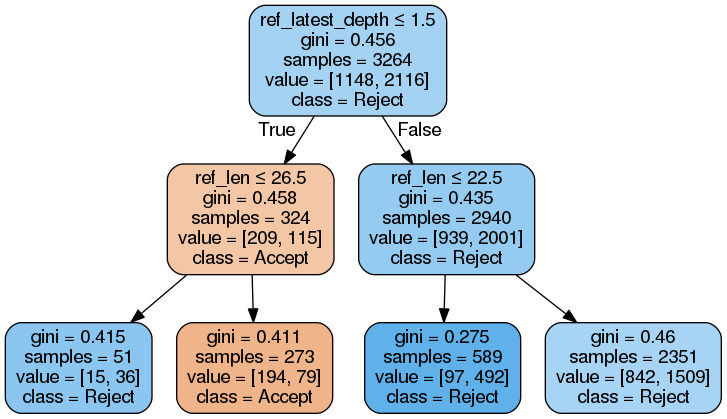

In [ ]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

for clf_name,clf in clf_dict.items():
    X = data.drop(columns=['id', 'label', 'ref_latest'])#, 'len_char_title', 'len_word_title', 'len_char_abstract', 'len_word_abstract'])
    y = data['label']
    X_normalized = X #/ X.max(axis=0)
    results = cross_validate(clf, X_normalized, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
    if clf_name == "DecisionTree":
        display(plot(clf))

In [ ]:
model_results

In [19]:
model_results

,Accuracy,CVresults
RandomForest,0.665712,"{'test_score': [0.6723821187997551, 0.66299019..."
LogisticLassoR,0.657752,"{'test_score': [0.6454378444580526, 0.66237745..."
GaussianProcessClf,0.652237,"{'test_score': [0.6454378444580526, 0.64950980..."
NeuralNet,0.66061,"{'test_score': [0.6546233925290875, 0.66421568..."
GaussNB,0.636106,"{'test_score': [0.6270667483159829, 0.63664215..."
LogisticR,0.659589,"{'test_score': [0.6503368034292712, 0.66421568..."
RidgeClf,0.658977,"{'test_score': [0.647887323943662, 0.659313725..."
DecisionTree,0.678374,"{'test_score': [0.6821800367421923, 0.67585784..."
SVC,0.648152,"{'test_score': [0.647887323943662, 0.648284313..."
KNN,0.614459,"{'test_score': [0.6099203919167177, 0.61274509..."


In [21]:
data.to_csv("features/reproducible_dataset_iclr_2017_2020.csv", encoding='utf-8', index=False)

In [ ]:
data = pd.read_csv("../features/reproducible_dataset_iclr_2017_2020.csv")

# Add new features

In [75]:
text_clarity_ldb_abl = pd.read_pickle("features/writing_clarity_ldb_abl.pkl")

In [76]:
text_clarity_ldb_abl.columns

Index(['cdate', 'content', 'ddate', 'details', 'forum', 'id', 'invitation',
       'label', 'nonreaders', 'number', 'original', 'readers', 'referent',
       'replyto', 'signatures', 'tcdate', 'tmdate', 'writers', 'title',
       'authors', 'abstract', 'keywords', 'tldr', 'ref_len', 'ref_latest',
       'ref_years', 'np_count_abs', 'nsubj_count_abs', 'dobj_count_abs',
       'np_count_title', 'cons_inters_abs', 'jc_cfp', 'ldb_table_count',
       'abl_table_count', 'abs_cons_cosine'],
      dtype='object')

In [77]:
new_features = ['np_count_abs', 'nsubj_count_abs', 'dobj_count_abs', 'np_count_title', 'cons_inters_abs', 
                'jc_cfp', 'ldb_table_count', 'abl_table_count', 'abs_cons_cosine']

In [78]:
print(data.shape)

(4897, 33)


In [79]:
for index, row in data.iterrows():
    for nf in new_features:
        data.loc[index, nf] = text_clarity_ldb_abl[text_clarity_ldb_abl["id"]==index][nf].get_values()[0]

In [80]:
data.columns, data.shape

(Index(['id', 'n_authors', 'len_char_title', 'len_word_title',
        'len_char_abstract', 'len_word_abstract', 'n_keywords', 'ref_len',
        'ref_latest', 'num_recent_refs', 'contains_ml_keyword', 'avg_sent_len',
        'abs_glove_avg', 'contains_sota', 'avg_ref_length', 'num_sections',
        'contains_appendix', 'fig_tab_eqn_count', 'contains_table',
        'contains_figure', 'contains_equation', 'iclr_references', 'label',
        'ref_latest_depth', 'np_count_abs', 'nsubj_count_abs', 'dobj_count_abs',
        'np_count_title', 'cons_inters_abs', 'jc_cfp', 'ldb_table_count',
        'abl_table_count', 'abs_cons_cosine'],
       dtype='object'), (4897, 33))

In [81]:
data.head(5)

,id,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,n_keywords,ref_len,ref_latest,num_recent_refs,...,ref_latest_depth,np_count_abs,nsubj_count_abs,dobj_count_abs,np_count_title,cons_inters_abs,jc_cfp,ldb_table_count,abl_table_count,abs_cons_cosine
2017_HJIY0E9ge,2017_HJIY0E9ge,3,70,12,823,121,1,22,2016,12,...,2,5.833333,1.500000,1.500000,0.0,1.800000,0.032258,0.0,0.0,0.657281
2017_BkdpaH9ll,2017_BkdpaH9ll,5,41,5,1076,149,2,30,2016,24,...,2,7.166667,1.000000,2.000000,2.0,1.400000,0.085714,2.0,0.0,0.668052
2020_rkecl1rtwB,2020_rkecl1rtwB,2,40,6,918,134,3,16,2019,12,...,2,5.166667,2.333333,0.666667,1.0,0.800000,0.015152,0.0,3.0,0.672600
2019_HkgYmhR9KX,2019_HkgYmhR9KX,5,75,11,1761,266,4,36,2019,24,...,1,5.615385,1.615385,1.153846,4.0,1.500000,0.011364,0.0,0.0,0.652189
2020_ryxW804FPH,2020_ryxW804FPH,3,68,8,750,112,4,31,2019,20,...,2,4.857143,1.285714,1.857143,4.0,0.666667,0.048387,0.0,0.0,0.689445


In [82]:
data[data.isnull().any(axis=1)]

,id,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,n_keywords,ref_len,ref_latest,num_recent_refs,...,ref_latest_depth,np_count_abs,nsubj_count_abs,dobj_count_abs,np_count_title,cons_inters_abs,jc_cfp,ldb_table_count,abl_table_count,abs_cons_cosine
2020_r1gx60NKPS,2020_r1gx60NKPS,5,55,8,355,57,7,17,2019,12,...,2,14.0,2.0,8.0,2.0,NaN,0.039216,0.0,0.0,NaN


In [91]:
data.loc["2020_r1gx60NKPS", "abs_cons_cosine"] = 0.0
data.loc["2020_r1gx60NKPS", "cons_inters_abs"] = 0.0

print(data[data["id"]=="2020_r1gx60NKPS"]["abs_cons_cosine"])

2020_r1gx60NKPS    0.0
Name: abs_cons_cosine, dtype: float64


In [92]:
data[data.isnull().any(axis=1)]

,id,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,n_keywords,ref_len,ref_latest,num_recent_refs,...,ref_latest_depth,np_count_abs,nsubj_count_abs,dobj_count_abs,np_count_title,cons_inters_abs,jc_cfp,ldb_table_count,abl_table_count,abs_cons_cosine


In [96]:
data.to_csv("features/FINAL_reproducible_dataset_iclr_2017_2020.csv", encoding='utf-8', index=False)

# Model

In [3]:
# Read reproducible data from file
data = pd.read_csv("features/FINAL_reproducible_dataset_iclr_2017_2020.csv")
print(data.shape)
data.head(2)

(4897, 33)


,id,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,n_keywords,ref_len,ref_latest,num_recent_refs,...,ref_latest_depth,np_count_abs,nsubj_count_abs,dobj_count_abs,np_count_title,cons_inters_abs,jc_cfp,ldb_table_count,abl_table_count,abs_cons_cosine
0,2017_HJIY0E9ge,3,70,12,823,121,1,22,2016,12,...,2,5.833333,1.5,1.5,0.0,1.8,0.032258,0.0,0.0,0.657281
1,2017_BkdpaH9ll,5,41,5,1076,149,2,30,2016,24,...,2,7.166667,1.0,2.0,2.0,1.4,0.085714,2.0,0.0,0.668052


In [3]:
data.shape, data.columns

((4897, 33), Index(['id', 'n_authors', 'len_char_title', 'len_word_title',
        'len_char_abstract', 'len_word_abstract', 'n_keywords', 'ref_len',
        'ref_latest', 'num_recent_refs', 'contains_ml_keyword', 'avg_sent_len',
        'abs_glove_avg', 'contains_sota', 'avg_ref_length', 'num_sections',
        'contains_appendix', 'fig_tab_eqn_count', 'contains_table',
        'contains_figure', 'contains_equation', 'iclr_references', 'label',
        'ref_latest_depth', 'np_count_abs', 'nsubj_count_abs', 'dobj_count_abs',
        'np_count_title', 'cons_inters_abs', 'jc_cfp', 'ldb_table_count',
        'abl_table_count', 'abs_cons_cosine'],
       dtype='object'))

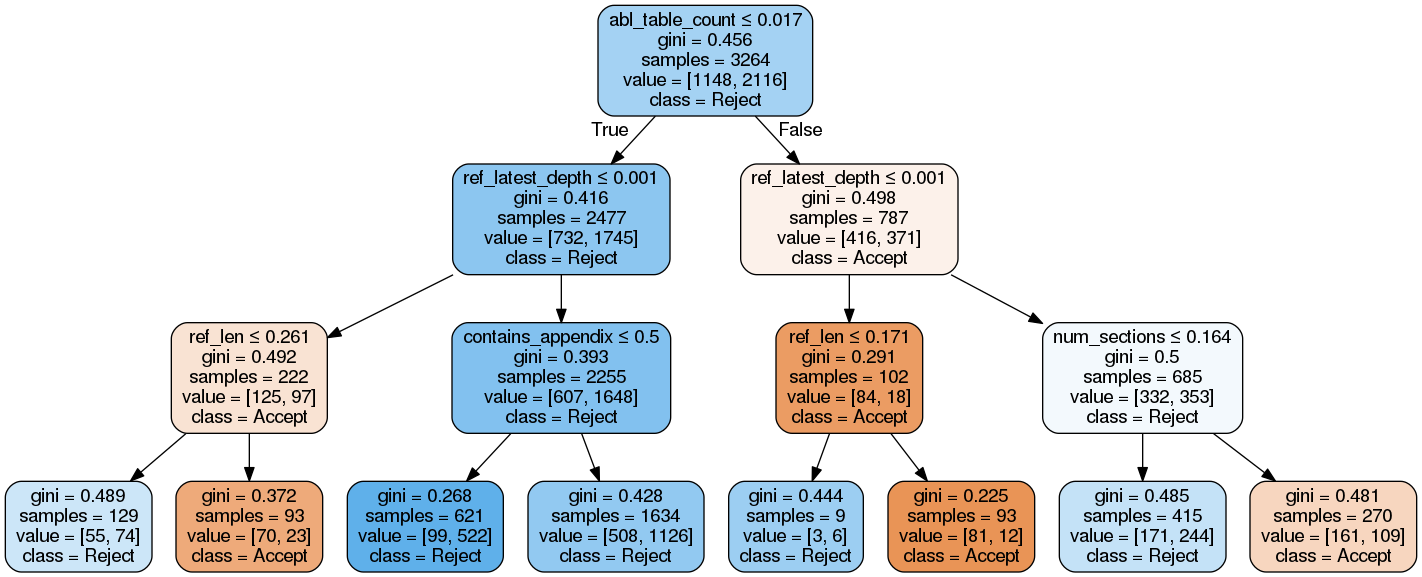

In [94]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

for clf_name,clf in clf_dict.items():
    X = data.drop(columns=['id', 'label', 'ref_latest'])#, 'len_char_title', 'len_word_title', 'len_char_abstract', 'len_word_abstract'])
    y = data['label']
    X_normalized = X / X.max(axis=0)
    results = cross_validate(clf, X_normalized, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
    if clf_name == "DecisionTree":
        display(plot(clf))

In [95]:
model_results

,Accuracy,CVresults
RandomForest,0.677352,"{'test_score': [0.683404776484997, 0.667279411..."
LogisticLassoR,0.674904,"{'test_score': [0.6723821187997551, 0.67279411..."
GaussianProcessClf,0.669389,"{'test_score': [0.6729944886711574, 0.66237745..."
NeuralNet,0.679396,"{'test_score': [0.6785058175137784, 0.68198529..."
GaussNB,0.661632,"{'test_score': [0.6491120636864667, 0.66666666..."
LogisticR,0.674903,"{'test_score': [0.6736068585425597, 0.67218137..."
RidgeClf,0.675107,"{'test_score': [0.6748315982853643, 0.67279411..."
DecisionTree,0.683478,"{'test_score': [0.6907532149418248, 0.67524509..."
SVC,0.648152,"{'test_score': [0.647887323943662, 0.648284313..."
KNN,0.610374,"{'test_score': [0.6093080220453154, 0.60784313..."


In [16]:
with open("./mag_data_extraction/runnnnn.pkl", "rb") as f:
    gs_pub_cit = pickle.load(f)

In [17]:
list(gs_pub_cit.items())[0:3]

[('2020_rkewaxrtvr',
  {'authors': ['Tassilo Klein', 'Moin Nabi'],
   'cit_count_gs': [532, 548],
   'hindex': [],
   'id': '2020_rkewaxrtvr',
   'label': 'Reject',
   'pub_count_gs': [46, 54],
   'title': 'Privacy-preserving Representation Learning by Disentanglement'}),
 ('2019_SygQvs0cFQ',
  {'authors': ['Wang Ling',
    'Lingpeng Kong',
    'Lei Yu',
    'Gabor Melis',
    'Dani Yogatama'],
   'cit_count_gs': [1841, 542, 573, 231, 2273],
   'hindex': [],
   'id': '2019_SygQvs0cFQ',
   'label': 'Accept',
   'pub_count_gs': [50, 22, 12, 8, 25],
   'title': 'Variational Smoothing in Recurrent Neural Network Language Models'}),
 ('2020_rkxawlHKDr',
  {'authors': ['Tal Shaharabany', 'Lior Wolf', 'Shir Gur'],
   'cit_count_gs': [30423],
   'hindex': [],
   'id': '2020_rkxawlHKDr',
   'label': 'Accept',
   'pub_count_gs': [275],
   'title': 'End to End Trainable Active Contours via Differentiable Rendering'})]

In [ ]:
clf_dict = {'DecisionTree':DecisionTreeClassifier(max_depth=2),
            'RandomForest':RandomForestClassifier(n_estimators=50, max_depth=5),
            'LogisticR':LogisticRegression(max_iter=1000),
            'LogisticLassoR':LogisticRegression(max_iter=1000, penalty='l1',solver='liblinear'),
            'RidgeClf':RidgeClassifier(max_iter=1000),
            'SVC':SVC(kernel='rbf'),
#             'SVCPoly': SVC(kernel='poly', degree=3, gamma='auto'),
            'SVCLin': SVC(kernel='linear'),
            'GaussNB':GaussianNB(),
            'NeuralNet':MLPClassifier((100, 50),activation='logistic'),
            'KNN':KNeighborsClassifier(n_neighbors=4),
#             'GaussianProcessClf':GaussianProcessClassifier(kernel=kls.RBF())
            }

DecisionTree


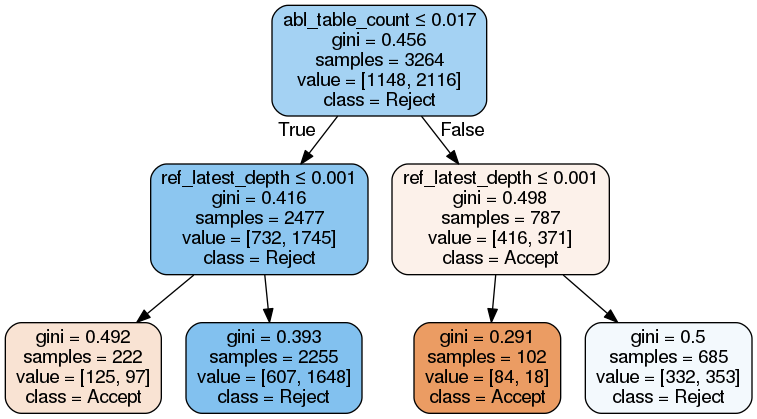

KNN
LogisticR
LogisticLassoR
SVC
NeuralNet
GaussNB
RidgeClf
RandomForest
SVCLin


In [59]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

for clf_name,clf in clf_dict.items():
    print(clf_name)
    X = data.drop(columns=['id', 'label', 'ref_latest'])#, 'len_char_title', 'len_word_title', 'len_char_abstract', 'len_word_abstract'])
    y = data['label']
    X_normalized = X / X.max(axis=0)
    results = cross_validate(clf, X_normalized, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
    if clf_name == "DecisionTree":
        display(plot(clf))

In [60]:
model_results

,Accuracy,CVresults
DecisionTree,0.673677,"{'score_time': [0.004880666732788086, 0.005435..."
KNN,0.570964,"{'score_time': [0.2527318000793457, 0.24862504..."
LogisticR,0.674496,"{'score_time': [0.01372838020324707, 0.0118062..."
LogisticLassoR,0.67715,"{'score_time': [0.011076211929321289, 0.010767..."
SVC,0.648152,"{'score_time': [0.336214542388916, 0.342661142..."
NeuralNet,0.674904,"{'score_time': [0.029854536056518555, 0.029103..."
GaussNB,0.659591,"{'score_time': [0.01306772232055664, 0.0052614..."
RidgeClf,0.676538,"{'score_time': [0.01120901107788086, 0.0119528..."
RandomForest,0.696754,"{'score_time': [0.016872406005859375, 0.016822..."
SVCLin,0.666122,"{'score_time': [0.16873478889465332, 0.1670336..."


In [18]:
def get_max_pub(pid):
    if gs_pub_cit[pid]["pub_count_gs"]:
        return max(gs_pub_cit[pid]["pub_count_gs"])
    else:
        return 0

In [19]:
def get_max_cit(pid):
    if gs_pub_cit[pid]["cit_count_gs"]:
        return max(gs_pub_cit[pid]["cit_count_gs"])
    else:
        return 0

In [20]:
data["gs_pub"] = data["id"].apply(get_max_pub)
data["gs_cit"] = data["id"].apply(get_max_cit)

In [21]:
data.columns

Index(['id', 'n_authors', 'len_char_title', 'len_word_title',
       'len_char_abstract', 'len_word_abstract', 'n_keywords', 'ref_len',
       'ref_latest', 'num_recent_refs', 'contains_ml_keyword', 'avg_sent_len',
       'abs_glove_avg', 'contains_sota', 'avg_ref_length', 'num_sections',
       'contains_appendix', 'fig_tab_eqn_count', 'contains_table',
       'contains_figure', 'contains_equation', 'iclr_references', 'label',
       'ref_latest_depth', 'np_count_abs', 'nsubj_count_abs', 'dobj_count_abs',
       'np_count_title', 'cons_inters_abs', 'jc_cfp', 'ldb_table_count',
       'abl_table_count', 'abs_cons_cosine', 'gs_pub', 'gs_cit'],
      dtype='object')

In [22]:
data.head(2)

,id,n_authors,len_char_title,len_word_title,len_char_abstract,len_word_abstract,n_keywords,ref_len,ref_latest,num_recent_refs,...,nsubj_count_abs,dobj_count_abs,np_count_title,cons_inters_abs,jc_cfp,ldb_table_count,abl_table_count,abs_cons_cosine,gs_pub,gs_cit
0,2017_HJIY0E9ge,3,70,12,823,121,1,22,2016,12,...,1.5,1.5,0.0,1.8,0.032258,0.0,0.0,0.657281,819,19175
1,2017_BkdpaH9ll,5,41,5,1076,149,2,30,2016,24,...,1.0,2.0,2.0,1.4,0.085714,2.0,0.0,0.668052,288,5848


In [77]:
clf_dict = {'DecisionTree':DecisionTreeClassifier(max_depth=2),
            'RandomForest':RandomForestClassifier(n_estimators=50, max_depth=5),
            'LogisticR':LogisticRegression(max_iter=1000),
            'LogisticLassoR':LogisticRegression(max_iter=1000, penalty='l1',solver='liblinear'),
            'RidgeClf':RidgeClassifier(max_iter=1000),
            'SVC':SVC(kernel='rbf'),
#             'SVCPoly': SVC(kernel='poly', degree=3, gamma='auto'),
            'SVCLin': SVC(kernel='linear'),
            'GaussNB':GaussianNB(),
            'NeuralNet':MLPClassifier((100, 50),activation='logistic'),
            'KNN':KNeighborsClassifier(n_neighbors=4),
#             'GaussianProcessClf':GaussianProcessClassifier(kernel=kls.RBF())
            }

DecisionTree


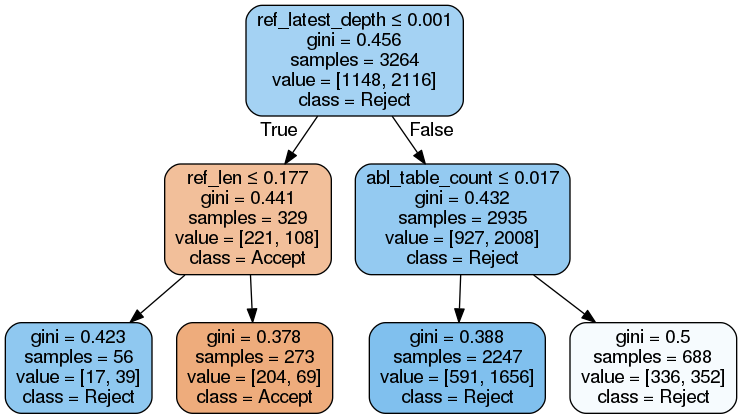

KNN
LogisticR
LogisticLassoR
SVC
NeuralNet
GaussNB
RidgeClf
RandomForest
SVCLin


In [82]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

data = data.sample(frac=1)

for clf_name,clf in clf_dict.items():
    print(clf_name)
    X = data.drop(columns=['id', 'label', 'ref_latest', "len_word_abstract"])#, 'len_char_title', 'len_word_title', 'len_char_abstract', 'len_word_abstract'])
    y = data['label']
    X_normalized = X / X.max(axis=0)
    results = cross_validate(clf, X_normalized, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[clf_name, ['Accuracy', 'CVresults']] = [accuracy, results]
    if clf_name == "DecisionTree":
        display(plot(clf))

In [83]:
model_results

,Accuracy,CVresults
DecisionTree,0.672045,"{'score_time': [0.004837989807128906, 0.004872..."
KNN,0.57852,"{'score_time': [0.236433744430542, 0.212308645..."
LogisticR,0.677763,"{'score_time': [0.01504063606262207, 0.0119504..."
LogisticLassoR,0.678784,"{'score_time': [0.011275529861450195, 0.011911..."
SVC,0.648152,"{'score_time': [0.3270127773284912, 0.32474398..."
NeuralNet,0.677968,"{'score_time': [0.03330564498901367, 0.0289707..."
GaussNB,0.661836,"{'score_time': [0.012737512588500977, 0.005118..."
RidgeClf,0.67858,"{'score_time': [0.011440277099609375, 0.024601..."
RandomForest,0.694303,"{'score_time': [0.01738715171813965, 0.0165057..."
SVCLin,0.665918,"{'score_time': [0.1544055938720703, 0.15699958..."


In [81]:
model_results

,Accuracy,CVresults
DecisionTree,0.673677,"{'score_time': [0.004942178726196289, 0.005023..."
KNN,0.570145,"{'score_time': [0.24927663803100586, 0.2344841..."
LogisticR,0.674904,"{'score_time': [0.014827966690063477, 0.011774..."
LogisticLassoR,0.67715,"{'score_time': [0.011474847793579102, 0.011080..."
SVC,0.648152,"{'score_time': [0.3225581645965576, 0.32738399..."
NeuralNet,0.675517,"{'score_time': [0.031287431716918945, 0.028740..."
GaussNB,0.66102,"{'score_time': [0.012927532196044922, 0.005226..."
RidgeClf,0.675721,"{'score_time': [0.009293794631958008, 0.011346..."
RandomForest,0.69512,"{'score_time': [0.01666569709777832, 0.0164141..."
SVCLin,0.666326,"{'score_time': [0.15441298484802246, 0.1562845..."


In [28]:
model_results

,Accuracy,CVresults
DecisionTree,0.673677,"{'score_time': [0.0049207210540771484, 0.00488..."
GaussianProcessClf,0.667143,"{'score_time': [0.40102171897888184, 0.3876664..."
LogisticR,0.674496,"{'score_time': [0.011159420013427734, 0.012079..."
LogisticLassoR,0.67715,"{'score_time': [0.011244773864746094, 0.011137..."
NeuralNet,0.676743,"{'score_time': [0.028958559036254883, 0.029967..."
GaussNB,0.659591,"{'score_time': [0.012962102890014648, 0.005253..."
RidgeClf,0.676538,"{'score_time': [0.010812044143676758, 0.011675..."
RandomForest,0.676944,"{'score_time': [0.007302522659301758, 0.007199..."


In [7]:
cols = list(data.columns)
print(cols)

['id', 'n_authors', 'len_char_title', 'len_word_title', 'len_char_abstract', 'len_word_abstract', 'n_keywords', 'ref_len', 'ref_latest', 'num_recent_refs', 'contains_ml_keyword', 'avg_sent_len', 'abs_glove_avg', 'contains_sota', 'avg_ref_length', 'num_sections', 'contains_appendix', 'fig_tab_eqn_count', 'contains_table', 'contains_figure', 'contains_equation', 'iclr_references', 'label', 'ref_latest_depth', 'np_count_abs', 'nsubj_count_abs', 'dobj_count_abs', 'np_count_title', 'cons_inters_abs', 'jc_cfp', 'ldb_table_count', 'abl_table_count', 'abs_cons_cosine']


In [8]:
cols.remove("id")
cols.remove("label")
cols.remove("ref_latest")

In [ ]:
train_test_split(X_normalized, y, test_size=0.20)

In [36]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
# model_results['feature'] = None


# for column_leave in cols:
# for i in range(0,5):
X = data.drop(columns=['id', 'label', "len_word_abstract", "ref_latest"])
y = data['label']
X_normalized = X / X.max(axis=0)
#     clf = LogisticRegression(max_iter=1000, penalty='l1',solver='liblinear')
x_train, x_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.30)
clf = RandomForestClassifier(n_estimators=50, max_depth=5)
clf.fit(x_train, y_train)

y_predicted = clf.predict(x_test)

clsr = classification_report(y_test, y_predicted, target_names=["Reject", "Accept"])
print(clsr)
# results = cross_validate(clf, X_normalized, y, return_estimator=True)
# clf = results['estimator']
# results.pop('estimator')
# accuracy = np.mean(results['test_score'])
# model_results.loc[column_leave, ['Accuracy']] = [accuracy]


              precision    recall  f1-score   support

      Reject       0.70      0.27      0.39       494
      Accept       0.72      0.94      0.81       976

    accuracy                           0.72      1470
   macro avg       0.71      0.61      0.60      1470
weighted avg       0.71      0.72      0.67      1470

              precision    recall  f1-score   support

      Reject       0.74      0.24      0.36       493
      Accept       0.71      0.96      0.82       977

    accuracy                           0.72      1470
   macro avg       0.73      0.60      0.59      1470
weighted avg       0.72      0.72      0.67      1470

              precision    recall  f1-score   support

      Reject       0.68      0.25      0.36       538
      Accept       0.68      0.93      0.79       932

    accuracy                           0.68      1470
   macro avg       0.68      0.59      0.57      1470
weighted avg       0.68      0.68      0.63      1470

              preci

In [37]:
(70 + 74 + 68 + 69 + 62)/5

68.6

In [38]:
(72+71+68+69+69)/5

69.8

In [40]:
from sklearn.metrics import classification_report, accuracy_score, make_scorer

In [42]:
def classification_report_with_accuracy_score(y_true, y_pred):

    print(classification_report(y_true, y_pred)) # print classification report

    return accuracy_score(y_true, y_pred) # return accuracy score

In [51]:
arr = []

X = data.drop(columns=['id', 'label', column_leave])
y = data['label']
X_normalized = X / X.max(axis=0)
clf = RandomForestClassifier(n_estimators=50, max_depth=5)

nested_score = cross_val_score(clf, X=X_normalized, y=y, cv=5, scoring=make_scorer(classification_report_with_accuracy_score))
print(nested_score)
print(np.mean(nested_score))
# results = cross_validate(clf, X_normalized, y, return_estimator=True)
# clf = results['estimator']
# results.pop('estimator')
# accuracy = np.mean(results['test_score'])

              precision    recall  f1-score   support

      Accept       0.69      0.24      0.36       345
      Reject       0.70      0.94      0.80       635

    accuracy                           0.69       980
   macro avg       0.69      0.59      0.58       980
weighted avg       0.69      0.69      0.64       980

              precision    recall  f1-score   support

      Accept       0.73      0.25      0.38       345
      Reject       0.70      0.95      0.81       635

    accuracy                           0.70       980
   macro avg       0.72      0.60      0.59       980
weighted avg       0.71      0.70      0.65       980

              precision    recall  f1-score   support

      Accept       0.64      0.22      0.33       345
      Reject       0.69      0.93      0.79       635

    accuracy                           0.68       980
   macro avg       0.67      0.58      0.56       980
weighted avg       0.67      0.68      0.63       980

              preci

In [52]:
#P
print((0.69+0.73+0.64+0.67+0.77)/5)
print((0.70+0.70+0.69+0.69+0.70)/5)

0.7
0.696


In [53]:
#REcall
print((.24+.25+.22+.22+.26)/5)
print((.94+.95+.93+.94+.96)/5)

0.238
0.944


In [49]:
X = data.drop(columns=['id', 'label', column_leave])
y = data['label']
X_normalized = X / X.max(axis=0)
clf = RandomForestClassifier(n_estimators=50, max_depth=5)
results = cross_validate(clf, X_normalized, y, cv=5, return_estimator=True)
clf = results['estimator']
results.pop('estimator')
accuracy = np.mean(results['test_score'])
print(accuracy)

0.6977785355919064


In [65]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
# model_results['feature'] = None


for column_leave in cols:
    X = data.drop(columns=['id', 'label', column_leave])
    y = data['label']
    X_normalized = X / X.max(axis=0)
#     clf = LogisticRegression(max_iter=8000, penalty='l1',solver='liblinear')
    clf = RandomForestClassifier(n_estimators=50, max_depth=5)
    results = cross_validate(clf, X_normalized, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[column_leave, ['Accuracy']] = [accuracy]


In [66]:
model_results.sort_values(by=["Accuracy"])

,Accuracy
ref_latest_depth,0.680008
abl_table_count,0.689606
num_sections,0.692465
ldb_table_count,0.692872
gs_pub,0.693078
iclr_references,0.693895
contains_appendix,0.694100
dobj_count_abs,0.694508
ref_len,0.694712
contains_sota,0.694712


In [16]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
# model_results['feature'] = None


# for column_leave in cols:
X = data.drop(columns=['id', 'label', 'len_word_abstract', 'ref_latest', 'num_sections'])
y = data['label']
X_normalized = X / X.max(axis=0)
#     clf = LogisticRegression(max_iter=8000, penalty='l1',solver='liblinear')
clf = RandomForestClassifier(n_estimators=50, max_depth=5)
results = cross_validate(clf, X_normalized, y, return_estimator=True)
clf = results['estimator']
results.pop('estimator')
accuracy = np.mean(results['test_score'])
print(accuracy)


# model_results.loc[column_leave, ['Accuracy']] = [accuracy]


0.6949162294025591


In [11]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
# model_results['feature'] = None


for column_leave in cols:
    X = data.drop(columns=['id', 'label', column_leave])
    y = data['label']
    X_normalized = X / X.max(axis=0)
#     clf = LogisticRegression(max_iter=8000, penalty='l1',solver='liblinear')
    clf = RandomForestClassifier(n_estimators=50, max_depth=5)
    results = cross_validate(clf, X_normalized, y, return_estimator=True)
    clf = results['estimator']
    results.pop('estimator')
    accuracy = np.mean(results['test_score'])
    model_results.loc[column_leave, ['Accuracy']] = [accuracy]

In [12]:
model_results.sort_values(by=["Accuracy"])

,Accuracy
ref_latest_depth,0.684500
abl_table_count,0.692057
np_count_abs,0.693487
ref_len,0.693691
abs_cons_cosine,0.694712
contains_appendix,0.695121
len_word_title,0.695323
ldb_table_count,0.695324
cons_inters_abs,0.695733
n_keywords,0.696141


In [32]:
model_results

,Accuracy
n_authors,0.675516
len_char_title,0.676946
len_word_title,0.676537
len_char_abstract,0.676537
len_word_abstract,0.676946
n_keywords,0.676742
ref_len,0.676742
num_recent_refs,0.676946
contains_ml_keyword,0.676946
avg_sent_len,0.675312


In [33]:
model_results.sort_values(by=["Accuracy"])

,Accuracy
abl_table_count,0.671229
ldb_table_count,0.671431
iclr_references,0.672250
gs_cit,0.673270
contains_appendix,0.675107
abs_glove_avg,0.675108
avg_sent_len,0.675312
cons_inters_abs,0.675312
n_authors,0.675516
abs_cons_cosine,0.675720


## Feature importance using Logistic Lasso

In [8]:
model_results = pd.DataFrame()
model_results['Accuracy'] = None
model_results['CVresults'] = None

X = data.drop(columns=['id', 'label', 'ref_latest'])#, 'len_char_title', 'len_word_title', 'len_char_abstract', 'len_word_abstract'])
y = data['label']
X_normalized = X / X.max(axis=0)

clf = LogisticRegression(max_iter=1000, penalty='l1',solver='liblinear')

results = cross_validate(clf, X_normalized, y, return_estimator=True)
clf = results['estimator']
results.pop('estimator')
accuracy = np.mean(results['test_score'])

print(accuracy)

0.6749035167241014


In [10]:
clf.feature_importances_

AttributeError: 'tuple' object has no attribute 'feature_importances_'